In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd "/content/drive/MyDrive/UNet-LiTs"

In [3]:
# !pwd

### Importing libraries

In [40]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from skimage.io import imread, imshow

seed = 42
np.random.seed = seed

In [44]:
import tensorflow as tf
print(tf.__version__)

2.8.2


## Loading mask Images

In [9]:
mask_list = []
for root, _, files in os.walk(MASK_PATH):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp', '.dcm')):
            mask_list.append(os.path.join(root, file))  # Store full paths
print("Example mask paths:", mask_list[:5])

Example mask paths: ['Dataset\\train_masks\\volume-0_slice_0.jpg', 'Dataset\\train_masks\\volume-0_slice_1.jpg', 'Dataset\\train_masks\\volume-0_slice_10.jpg', 'Dataset\\train_masks\\volume-0_slice_11.jpg', 'Dataset\\train_masks\\volume-0_slice_12.jpg']


In [10]:
IMG_WIDTH, IMG_HEIGHT = 128, 128
Y_train = np.zeros((len(mask_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [11]:
print("Total Mask images:", len(mask_list))

Total Mask images: 58638


### Preprocessing mask Images

In [12]:
for n, mask_path in tqdm(enumerate(mask_list), total=len(mask_list)):
    if not os.path.exists(mask_path):
        print(f"File not found: {mask_path}")
        continue  # Skip missing files

    img = imread(mask_path)
    img = img[:, :, np.newaxis] if len(img.shape) == 2 else img
    Y_train[n] = img  

100%|███████████████████████████████████████████████████████████████████████████| 58638/58638 [06:01<00:00, 162.39it/s]


In [13]:
img

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

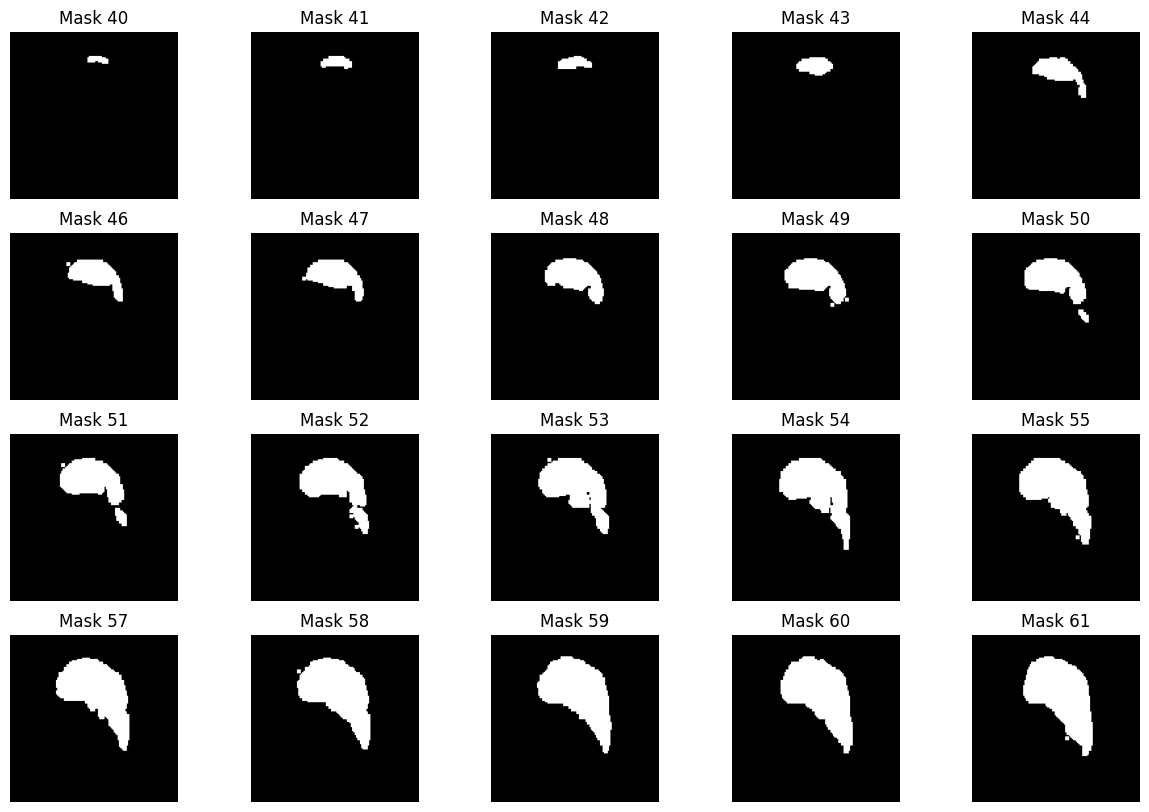

In [18]:
segmented_indices = [i for i in range(Y_train.shape[0]) if np.array_equal(np.unique(Y_train[i]), [0, 1])]

# Function to display selected mask images
def display_selected_masks(Y_train, selected_indices):
    """Displays selected mask images."""
    num_images = min(20, len(selected_indices))  # Ensure we don't exceed available images
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))  # Create 4x5 grid

    for i, idx in enumerate(selected_indices[:num_images]):
        ax = axes[i // 5, i % 5]  # Arrange in grid
        mask = Y_train[idx].squeeze()  # Remove the extra dimension
        ax.imshow(mask, cmap='gray')  # Display as grayscale
        ax.axis("off")
        ax.set_title(f"Mask {idx}")
    plt.show()

# Call the function to display masks
display_selected_masks(Y_train, segmented_indices)

## Loading Train Images

In [20]:
train_list = []
for root, _, files in os.walk(TRAIN_PATH):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp', '.dcm')):
            train_list.append(os.path.join(root, file))

print("Total train images:", len(train_list))

Total train images: 58638


### Preprocess Train images

In [22]:
for n, image_path in tqdm(enumerate(train_list), total=len(train_list)):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        continue  # Skip missing files
    X_train[n] = img 

100%|████████████████████████████████████████████████████████████████████████████| 58638/58638 [15:49<00:00, 61.73it/s]


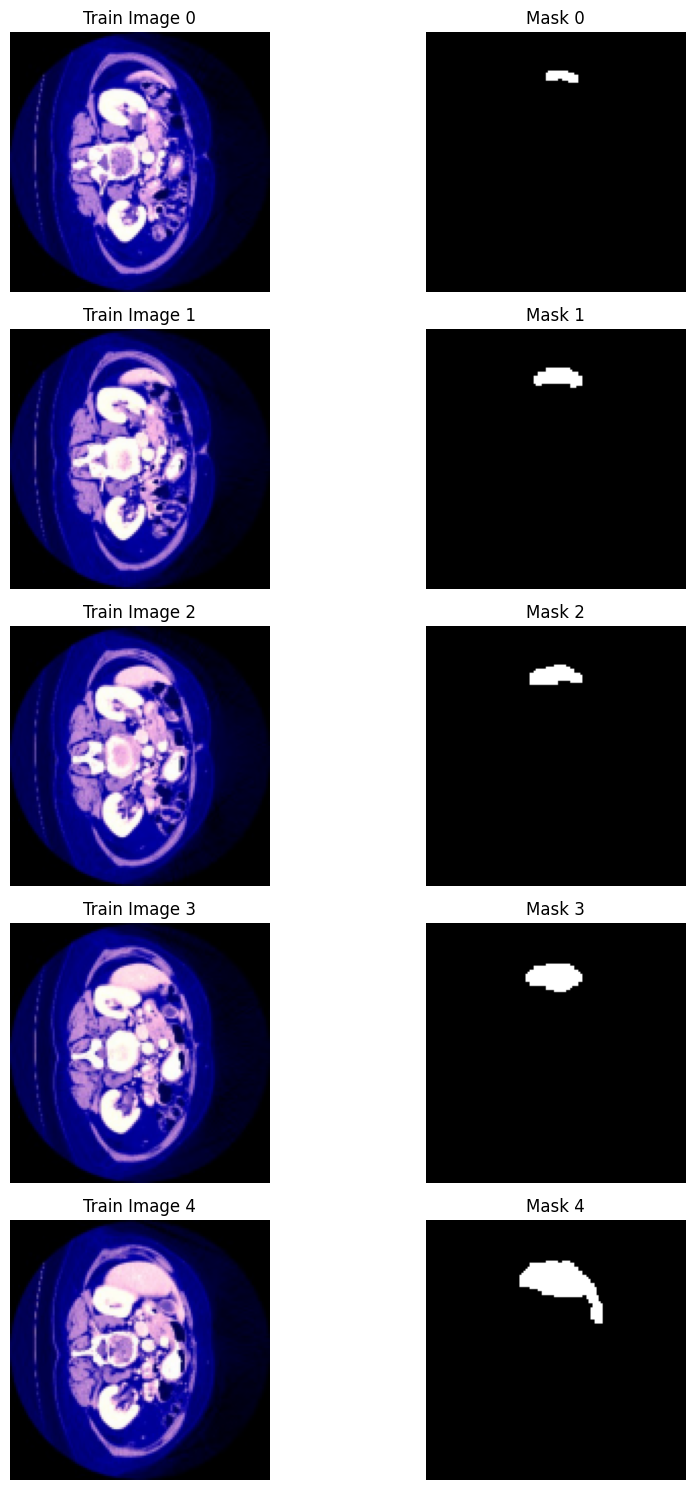

In [28]:
def display_samples(X_train, Y_train, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        axes[i, 0].imshow(X_train[i])  # Show training image
        axes[i, 0].set_title(f"Train Image {i}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(Y_train[i].squeeze(), cmap="gray")  # Show corresponding mask
        axes[i, 1].set_title(f"Mask {i}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()
display_samples(X_train_filtered, Y_train_filtered, num_samples=5)

## ResUnet Model

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout,
    Conv2DTranspose, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam


In [30]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = tf.keras.layers.Rescaling(1.0 / 255)(inputs)

In [31]:
def residual_block(x, filters, dropout_rate=0.1):
    """ Residual block with Conv2D and identity shortcut. """
    res = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    res = BatchNormalization()(res)
    res = Activation("relu")(res)

    res = Dropout(dropout_rate)(res)

    res = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal")(res)
    res = BatchNormalization()(res)

    # Residual connection
    shortcut = Conv2D(filters, (1, 1), padding="same")(x)  # Adjust dimensions if needed
    res = Add()([res, shortcut])
    res = Activation("relu")(res)

    return res

# Contraction Path (Encoder)
c3 = residual_block(p2, 64, 0.2)
p3 = MaxPooling2D((2, 2))(c3)

c4 = residual_block(p3, 128, 0.2)
p4 = MaxPooling2D((2, 2))(c4)

c5 = residual_block(p4, 256, 0.3)

# Expansion Path (Decoder)
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c7)
u8 = Add()([u8, c2])
c8 = residual_block(u8, 32, 0.1)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c8)
u9 = Add()([u9, c1])
c9 = residual_block(u9, 16, 0.1)

# Output Layer
outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

# Compile Model
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

 conv2d_9 (Conv2D)              (None, 16, 16, 128)  73856       ['max_pooling2d_2[0][0]']        
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 16, 16, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_6 (Activation)      (None, 16, 16, 128)  0           ['batch_normalization_6[0][0]']  
                                                                                                  
 dropout_3 (Dropout)            (None, 16, 16, 128)  0           ['activation_6[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 128)  147584      ['dropout_3[0][0]']              
          

                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 64)   0           ['activation_12[0][0]']          
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 64)   36928       ['dropout_6[0][0]']              
                                                                                                  
 batch_normalization_13 (BatchN  (None, 32, 32, 64)  256         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 64)   4160        ['add_7[0][0]']                  
                                                                                                  
 add_8 (Ad

In [32]:
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    TensorBoard(log_dir='logs')
]

# Train the Model
results = model.fit(
    X_train, Y_train,
    validation_split=0.1,  # 10% validation data
    batch_size=5,          # Adjust based on memory availability
    epochs=2,             # Increase epochs for better performance
    callbacks=callbacks,
    verbose=1
)

Epoch 1/2
3390/3390 [==============================] - 1116s 329ms/step - loss: 0.0327 - accuracy: 0.9872 - val_loss: 0.0342 - val_accuracy: 0.9876
Epoch 2/2
3390/3390 [==============================] - 1189s 351ms/step - loss: 0.0167 - accuracy: 0.9935 - val_loss: 0.0223 - val_accuracy: 0.9918


### Training and validation accuracy and loss at each epoch

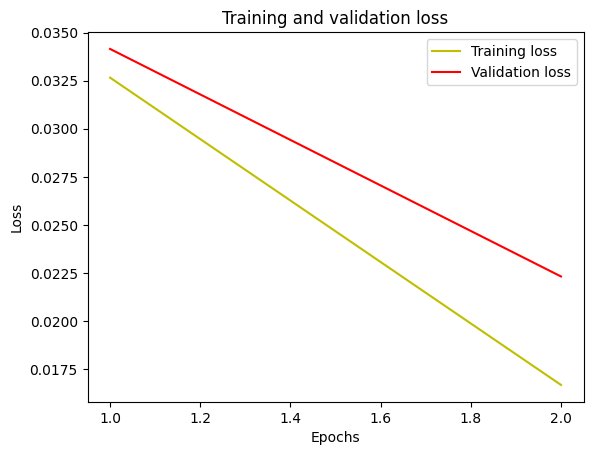

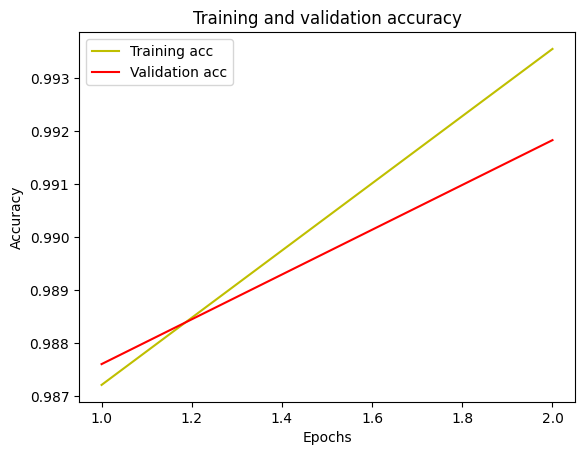

In [33]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Checking for a Random Image

In [36]:
idx = random.randint(0, len(X_train))

In [37]:
preds_test = model.predict(X_train, verbose=1)

589/589 [==============================] - 237s 402ms/step


In [38]:
preds_test.shape

(18834, 128, 128, 1)

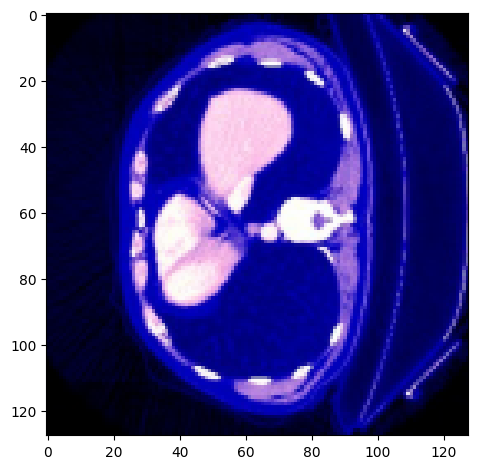

In [41]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test))
imshow(X_train[ix])
plt.show()

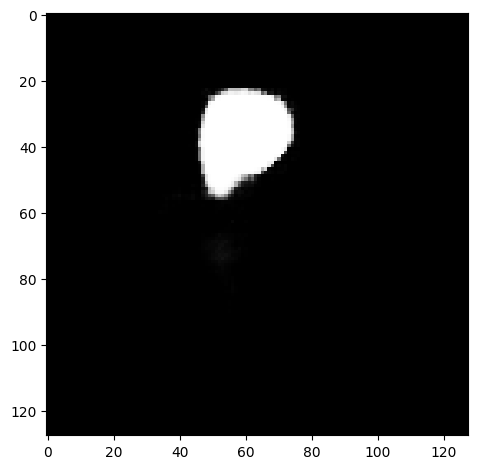

In [42]:
imshow(preds_test[ix])
plt.show()

### Calculating Mean Dice and IoU Score

In [45]:
from sklearn.metrics import jaccard_score

In [46]:
#Make Predictions
Y_pred = model.predict(X_train)
Y_pred = (Y_pred > 0.5).astype(np.uint8)

In [47]:
#Calculate Intersection over Union (IoU) for each mask
def calculate_iou(y_true, y_pred):
    ious = []
    for i in range(y_true.shape[0]):
        intersection = np.logical_and(y_true[i], y_pred[i]).sum()
        union = np.logical_or(y_true[i], y_pred[i]).sum()
        iou = intersection / union if union != 0 else 0  # Avoid division by zero
        ious.append(iou)
    return np.mean(ious)

In [48]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    dice_scores = []
    for i in range(y_true.shape[0]):
        intersection = np.logical_and(y_true[i], y_pred[i]).sum()
        total = y_true[i].sum() + y_pred[i].sum()
        dice = (2. * intersection) / total if total != 0 else 0  # Avoid division by zero
        dice_scores.append(dice)
    return np.mean(dice_scores)  # Return mean Dice score

In [50]:
mean_dice = dice_coefficient(Y_train, Y_pred)
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

Mean Dice Coefficient: 0.9397


In [49]:
mean_iou = calculate_iou(Y_train, Y_pred)
print(f"Mean IoU Score: {mean_iou:.4f}")

Mean IoU Score: 0.8980


In [ ]:
from skimage.metrics import structural_similarity as ssim
ssim_scores = [ssim(Y_train[i].squeeze(), Y_pred[i].squeeze(), data_range=1) for i in range(Y_train.shape[0])]
mean_ssim = np.mean(ssim_scores)
print(f"SSIM Score: {mean_ssim:.4f}")

In [51]:
def display_predictions(X_train, Y_train, Y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        axes[i, 0].imshow(X_train[i])  # Original Image
        axes[i, 0].set_title(f"Train Image {i}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(Y_train[i].squeeze(), cmap="gray")  # Ground Truth Mask
        axes[i, 1].set_title(f"Ground Truth {i}")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(Y_pred[i].squeeze(), cmap="gray")  # Predicted Mask
        axes[i, 2].set_title(f"Predicted Mask {i}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

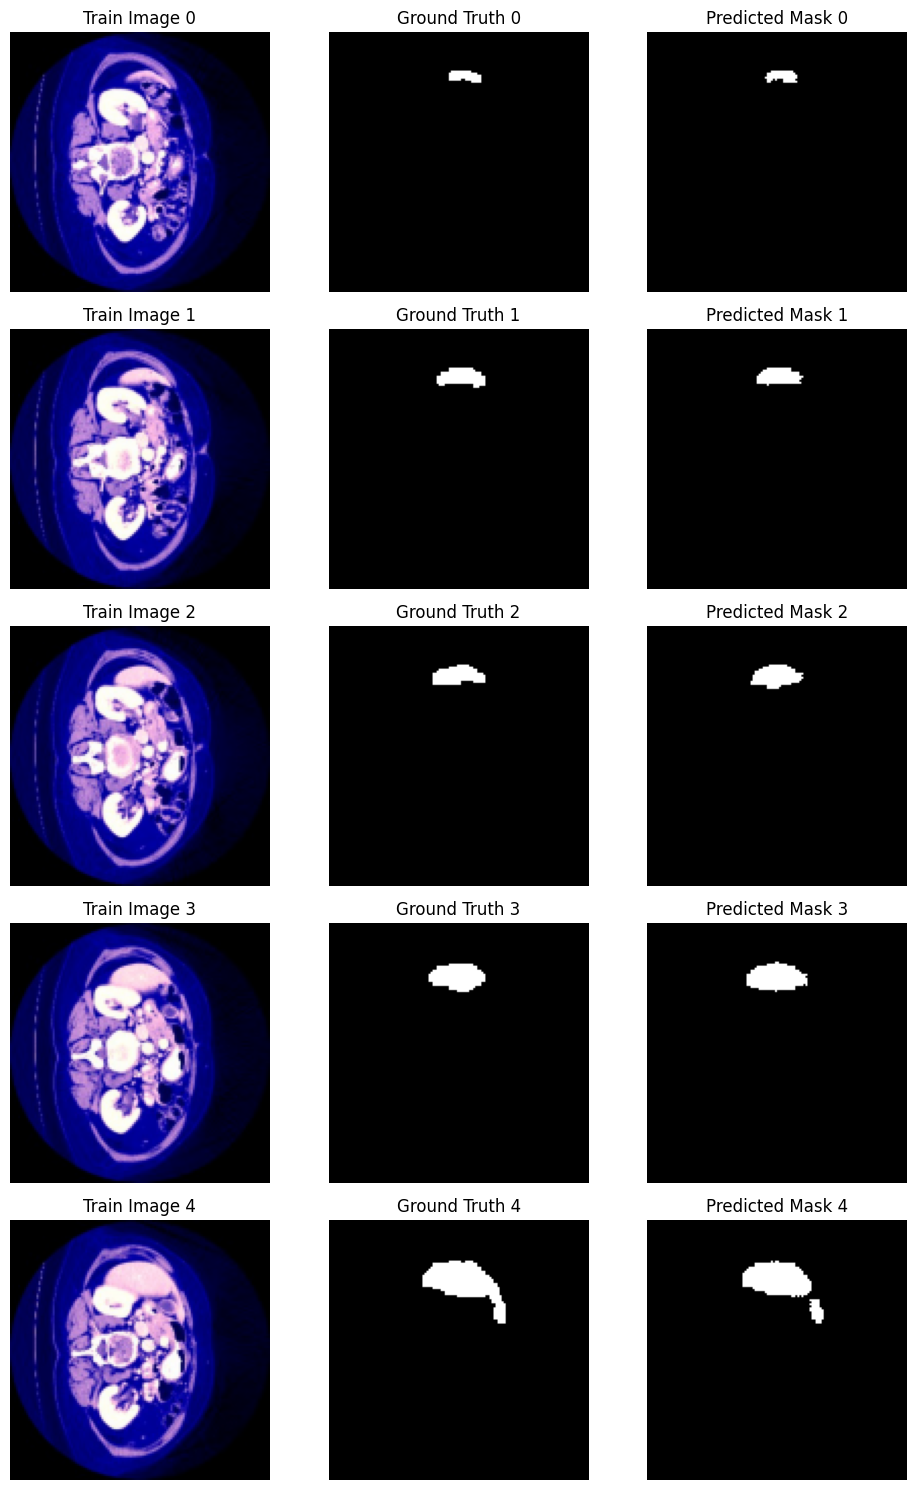

In [52]:
display_predictions(X_train, Y_train, Y_pred, num_samples=5)

### Saving Model

In [53]:
from pathlib import Path

model_structure = model.to_json()

model_dir = Path("models")
model_dir.mkdir(parents=True, exist_ok=True)

# Write the model structure to a JSON file
f = model_dir / "model_structure1.json"
f.write_text(model_structure)

41523

In [54]:
model.save_weights("models/model_weights.weights.h5")

---